In [56]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer


from sklearn.model_selection import KFold,StratifiedKFold
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot  as plt
import os

import joblib

#http://localhost:8888/lab/workspaces/auto-O/tree/MyQuantFinProject/LearnDataSC/Prasertcbs_ML/sklearn_feature_importances_with_treeclassifier.ipynb
#http://localhost:8888/lab/workspaces/auto-C/tree/MyQuantFinProject/LearnDataSC/Prasertcbs_ML/sklearn_classification_iris2.ipynb

In [57]:
dateTimeCols=['open_datetime','response_datetime','resolved_datetime','close_datetime']

cateFeatures=['product_type','brand','incident_type','service_type','is_failure_type','sla']
numericFeatures=['count_detail','open_to_close_hour','response_to_resolved_hour','open_to_response_hour','resolved_to_close_hour']

colLabel='severity_label'

colFeatures=cateFeatures+numericFeatures
cols=[colLabel]+colFeatures
print(cols)

isAutomaticOneHotByColumnTransformer=False

if  isAutomaticOneHotByColumnTransformer==True:
 isManualEncoding=False
else:
 isManualEncoding=True


useDMtrix=False


to_date='2023-12-31'

['severity_label', 'product_type', 'brand', 'incident_type', 'service_type', 'is_failure_type', 'sla', 'count_detail', 'open_to_close_hour', 'response_to_resolved_hour', 'open_to_response_hour', 'resolved_to_close_hour']


# Load and Prepare Data

In [58]:
df_incident = pd.read_csv('incident_data.csv',parse_dates=dateTimeCols)
print(f"Incident From {df_incident['open_datetime'].min()} To {df_incident['open_datetime'].max()}")
df_incident=df_incident.query("open_datetime<=@to_date")
df_incident=df_incident[cols]
print(df_incident.info())
df_incident.tail()



Incident From 2020-03-15 13:36:00 To 2023-02-01 06:40:00
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2094 entries, 0 to 2093
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   severity_label             2094 non-null   object 
 1   product_type               2094 non-null   object 
 2   brand                      2094 non-null   object 
 3   incident_type              2094 non-null   object 
 4   service_type               2094 non-null   object 
 5   is_failure_type            2094 non-null   bool   
 6   sla                        2094 non-null   object 
 7   count_detail               2094 non-null   int64  
 8   open_to_close_hour         2094 non-null   float64
 9   response_to_resolved_hour  2094 non-null   float64
 10  open_to_response_hour      2094 non-null   float64
 11  resolved_to_close_hour     2094 non-null   float64
dtypes: bool(1), float64(4), int64(1), object(6)
mem

,severity_label,product_type,brand,incident_type,service_type,is_failure_type,sla,count_detail,open_to_close_hour,response_to_resolved_hour,open_to_response_hour,resolved_to_close_hour
2089,Minor,Storage,YIP,General Incident,Request,False,24x7 6Hrs Resolution Time,1,67.250000,0.000000,67.250000,0.000000
2090,Major,Storage,NetApp,General Incident,Incident,False,24x7 4Hrs Response Time,3,365.316667,169.016667,2.633333,193.666667
2091,Major,Storage,NetApp,General Incident,Incident,False,24x7 4Hrs Response Time,2,20.166667,4.533333,0.550000,15.083333
2092,Major,Storage,NetApp,General Incident,Incident,False,24x7 4Hrs Response Time,1,23.783333,0.000000,23.783333,0.000000
2093,Major,Storage,NetApp,General Incident,Incident,False,24x7 4Hrs Response Time,2,31.150000,28.466667,1.450000,1.233333


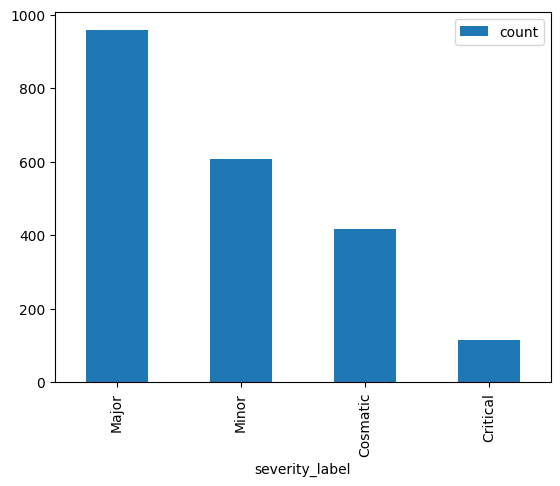

,count
severity_label,
Major,958
Minor,606
Cosmatic,416
Critical,114


In [59]:
dfLabel=df_incident.groupby([colLabel]).size().to_frame('count').sort_values(by='count',ascending=False)
dfLabel.plot(kind='bar')
plt.show()
dfLabel

# Process features and class

In [60]:
# cate_features=[ col for col in features if  col not in numericFeatures ]
if isAutomaticOneHotByColumnTransformer==False:
    
    if isManualEncoding==False:
        print("Let XGBoost encode itself")
    else:
        print("Encode by  LabelEncoder")
    features=[ col for col in list(df_incident.columns) if  col!=colLabel ]
    X = df_incident.loc[:,features]
    for cate_col in cateFeatures:
        if isManualEncoding==False:
              X[cate_col]=X[cate_col].astype("category")             
        else:  
            cateFeatEncoder = LabelEncoder()
            X[cate_col]=cateFeatEncoder.fit_transform(X[cate_col])

else:
        categorical_transformer = OneHotEncoder(sparse_output=False, handle_unknown="ignore")
        ct = ColumnTransformer(transformers=[("cat", categorical_transformer,cateFeatures )],remainder='passthrough')
        ct.set_output(transform='pandas')
        X = ct.fit_transform(df_incident)
        colLabel=f"remainder__{colLabel}"
        print(f"{colLabel} :OneHot Encoding to Fetures by ColumnTransformer")
        


Encode by  LabelEncoder


In [61]:
print(X.info())
X.tail()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2094 entries, 0 to 2093
Data columns (total 11 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   product_type               2094 non-null   int32  
 1   brand                      2094 non-null   int32  
 2   incident_type              2094 non-null   int32  
 3   service_type               2094 non-null   int32  
 4   is_failure_type            2094 non-null   int64  
 5   sla                        2094 non-null   int32  
 6   count_detail               2094 non-null   int64  
 7   open_to_close_hour         2094 non-null   float64
 8   response_to_resolved_hour  2094 non-null   float64
 9   open_to_response_hour      2094 non-null   float64
 10  resolved_to_close_hour     2094 non-null   float64
dtypes: float64(4), int32(5), int64(2)
memory usage: 155.4 KB
None


,product_type,brand,incident_type,service_type,is_failure_type,sla,count_detail,open_to_close_hour,response_to_resolved_hour,open_to_response_hour,resolved_to_close_hour
2089,7,19,7,1,0,2,1,67.250000,0.000000,67.250000,0.000000
2090,7,10,7,0,0,1,3,365.316667,169.016667,2.633333,193.666667
2091,7,10,7,0,0,1,2,20.166667,4.533333,0.550000,15.083333
2092,7,10,7,0,0,1,1,23.783333,0.000000,23.783333,0.000000
2093,7,10,7,0,0,1,2,31.150000,28.466667,1.450000,1.233333


In [62]:
if isAutomaticOneHotByColumnTransformer==False:
    Y = df_incident.loc[:,[colLabel]]
    Y[colLabel]=Y[colLabel].astype("category")    
else:
    Y=X.pop(colLabel)
    # # X=X.pop(colLabel)

print(Y.info())
Y[:5]

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2094 entries, 0 to 2093
Data columns (total 1 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   severity_label  2094 non-null   category
dtypes: category(1)
memory usage: 18.6 KB
None


,severity_label
0,Major
1,Major
2,Major
3,Minor
4,Major


In [63]:
print(X.info())
X.head(5)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2094 entries, 0 to 2093
Data columns (total 11 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   product_type               2094 non-null   int32  
 1   brand                      2094 non-null   int32  
 2   incident_type              2094 non-null   int32  
 3   service_type               2094 non-null   int32  
 4   is_failure_type            2094 non-null   int64  
 5   sla                        2094 non-null   int32  
 6   count_detail               2094 non-null   int64  
 7   open_to_close_hour         2094 non-null   float64
 8   response_to_resolved_hour  2094 non-null   float64
 9   open_to_response_hour      2094 non-null   float64
 10  resolved_to_close_hour     2094 non-null   float64
dtypes: float64(4), int32(5), int64(2)
memory usage: 155.4 KB
None


,product_type,brand,incident_type,service_type,is_failure_type,sla,count_detail,open_to_close_hour,response_to_resolved_hour,open_to_response_hour,resolved_to_close_hour
0,5,7,8,0,0,1,2,5.333333,5.000000,0.333333,0.000000
1,7,4,8,0,0,4,2,30.450000,10.683333,0.083333,19.683333
2,5,7,10,0,0,1,2,6.833333,6.500000,0.333333,0.000000
3,5,7,7,0,0,0,8,48.700000,48.516667,0.183333,0.000000
4,7,10,8,0,0,1,1,22.650000,0.200000,1.016667,21.433333


# Encode string class values as integers

In [64]:
label_encoder = LabelEncoder()
ylabelEncoded = label_encoder.fit_transform(Y)

print(f"Encode Fitting : {label_encoder.classes_}")

ylabelEncoded = ylabelEncoded.ravel()

print(ylabelEncoded[-5:])
print(ylabelEncoded.shape)

Encode Fitting : ['Cosmatic' 'Critical' 'Major' 'Minor']
[3 2 2 2 2]
(2094,)


D:\ProgramData\Anaconda3\envs\dev_ml_local\lib\site-packages\sklearn\preprocessing\_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


# Parameter Setting

In [65]:
maxDept=10
lerningRate=0.1
nEstimators=100

# Final Model

In [66]:
# print(X.shape,ylabelEncoded.shape)
# model = xgb.XGBClassifier(max_depth=maxDept,learning_rate=lerningRate,n_estimators=nEstimators)
# model_xg.fit(X, ylabelEncoded)

In [67]:
# artifact_filename = 'model.bst'
# local_path = artifact_filename

# model_xg.save_model(local_path)


# file_scaler_pred=f'{model_path}/scaler_pred_{modelName}.gz'
# joblib.dump(scalerFinalTrain,file_scaler)

In [68]:
# from google.cloud import storage

# BUCKET_NAME='gs://smart-ai-model-pongthorn'
# MODEL_DIR = BUCKET_NAME + "/model"
# print(MODEL_DIR)


# storage_path = os.path.join(MODEL_DIR, artifact_filename)
# blob = storage.blob.Blob.from_string(storage_path, client=storage.Client())
# blob.upload_from_filename(local_path)

# storage_client = storage.Client()
# blob = storage.blob.Blob.from_string(MODEL_DIR, client=storage.Client())
# blob.upload_from_filename(local_path)

# Train Data 

# Split Train and Test Data

In [69]:
seed = 7
test_size = 0.2
X_train, X_test, y_train, y_test = train_test_split(X, ylabelEncoded, test_size=test_size, random_state=seed)
print(X_train.shape,X_test.shape)
print(y_train.shape,y_test.shape)

print("---------------------------------------------------------------------------------------")
print(y_train[:5])
X_train[:5]



(1675, 11) (419, 11)
(1675,) (419,)
---------------------------------------------------------------------------------------
[0 0 3 0 0]


,product_type,brand,incident_type,service_type,is_failure_type,sla,count_detail,open_to_close_hour,response_to_resolved_hour,open_to_response_hour,resolved_to_close_hour
363,6,16,7,1,0,1,1,8.100000,8.000000,0.100000,0.0
1693,7,7,7,1,0,0,1,10.383333,8.000000,2.383333,0.0
210,6,16,18,0,0,1,2,1.916667,1.816667,0.100000,0.0
410,6,16,7,1,0,1,1,1.500000,1.000000,0.500000,0.0
281,5,7,4,1,0,0,2,7.000000,6.500000,0.500000,0.0


# XGBoost 

In [70]:


if useDMtrix==False:
    print("Use XGBClassifier Object")

    # Supported tree methods are `gpu_hist`, `approx`, and `hist`.
    if isManualEncoding==True or isAutomaticOneHotByColumnTransformer==True:
        print("XGBClassifier()")
        model_xg = xgb.XGBClassifier(max_depth=maxDept,learning_rate=lerningRate,n_estimators=nEstimators)
    else:
       print("XGBClassifier(enable_categorical=True,tree_method=hist)")
       model_xg = xgb.XGBClassifier(enable_categorical=True,tree_method="hist",\
                                    max_depth=maxDept,learning_rate=lerningRate,n_estimators=nEstimators)
    #use_label_encoder    
    # print(model_xg)
    model_xg.fit(X_train, y_train)
    y_pred_xg = model_xg.predict(X_test)

else:

    print("Use DMatrix & Train Object") 
    xg_param= {'max_depth': maxDept, 'learning_rate': lerningRate}
    dtrain = xgb.DMatrix(X_train, label=y_train,enable_categorical=True,)
    model_xg=xgb.train(xg_param,dtrain,num_boost_round=nEstimators)
    dtest = xgb.DMatrix(X_test,y_test,enable_categorical=True)
    y_pred_xg = model_xg.predict(dtest)


Use XGBClassifier Object
XGBClassifier()


In [72]:

predictions_xg = [round(value) for value in y_pred_xg]

accuracy_xg = accuracy_score(y_test, predictions_xg)
print("XGBoost Accuracy: %.2f%%" % (accuracy_xg * 100.0))

XGBoost Accuracy: 76.13%


# Feature Important

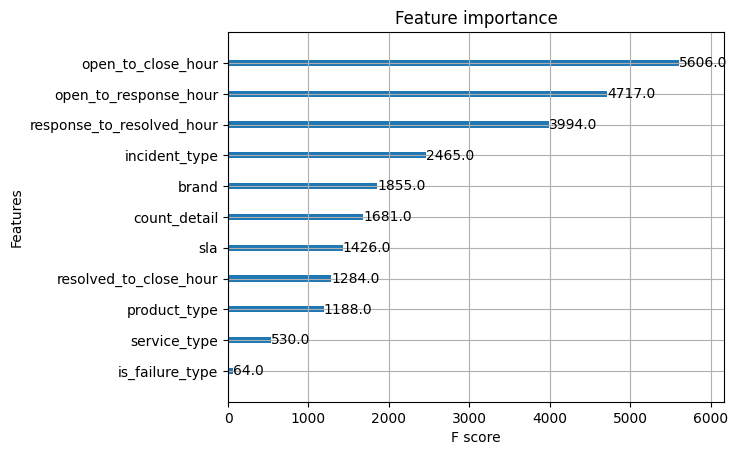

In [73]:
xgb.plot_importance(model_xg)
plt.show()